In [1]:
# imports
from os.path import join
import glob
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from pymatreader import read_mat
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from scipy.stats import zscore
%matplotlib inline

In [2]:
# paths
EEG_PREDICTION_CORR_PATH = 'data/eeg_prediction_corr.mat'
PREDICTION_MATRIX_PATH = 'data/prediction_matrices/'

In [3]:
def load_data_f2():
    
    """Loads, zscores and formats the data needed to create figure 2."""
    
    data = read_mat(EEG_PREDICTION_CORR_PATH)
    correlations = {key : pd.DataFrame(val)
                    for key, val in data['correlation'].items()}
    
    # put the correlation coefficients from real and randomized data in the same dataframe for plotting
    df = pd.concat([correlations['correlation_real'], correlations['correlation_randomized']], axis=1)
    df.columns = ['correlation_real', 'correlation_randomized']
    df.sort_values(by='correlation_real', ascending=False, inplace=True)
    
    # load the predictions
    predictions = {key : pd.DataFrame(val).apply(zscore)
                   for key, val in data['predictions'].items()}
    
    # load the eeg data
    eeg = {key : pd.DataFrame(val).transpose().apply(zscore)
           for key, val in data['eeg'].items()}
    
    # load prediction matrices
    flist = glob.glob(join(PREDICTION_MATRIX_PATH, '*_prediction.mat'))

    data_nested = [read_mat(file) for file in flist]
    
    prediction_matrices = [data_nested[ind]['pred']['pred_10k']
                           for ind in range(1,len(data_nested))]
    
    return df, correlations, predictions, eeg, prediction_matrices

In [4]:
def r2z_test(r1,r2,n1,n2):
    
    """
    A fisher test to compare the correlation between random and real correlations
    based on https://www.mathworks.com/matlabcentral/fileexchange/44658-compare_correlation_coefficients.
    Results match the ones obtained from matlab.
    
    See below the documentation as obtained from matlab.
    
    % This function compares if two correlation coefficients are significantly
    % different.
    % The correlation coefficients were tansfered to z scores using fisher's r
    % to z transformation.
    % ref: http://core.ecu.edu/psyc/wuenschk/docs30/CompareCorrCoeff.pdf
    %--------------------------------------------------------------------------
    % Inputs: (1) r1: correlation coefficient of the first correlation (2) r2:
    % correlation coefficient of the second correlation (3) n1: number of
    % samples used to compute the first correlation (4) n2: number of samples
    % used to compute the second correlation
    %--------------------------------------------------------------------------
    % Output: (1) p: p value, the probability that H0 (the correlation
    % coefficiets are not different) is correct
    %--------------------------------------------------------------------------
    % Example :
    % x = rand(20,1);
    % y1= x+rand(20,1)*0.05;
    % y2= x+rand(20,1)*0.5;
    % r1=corr(x,y1);
    % r1=corr(x,y2);
    % p = compare_correlation_coefficients(r1,r2,length(x),length(x));
    %--------------------------------------------------------------------------
    Sisi Ma (2020). compare_correlation_coefficients (https://www.mathworks.com/matlabcentral/fileexchange/44658-compare_correlation_coefficients), MATLAB Central File Exchange. Retrieved June 3, 2020.
    """
    
    t_r1 = 0.5*np.log((1+r1)/(1-r1))
    t_r2 = 0.5*np.log((1+r2)/(1-r2))
    z = (t_r1-t_r2)/np.sqrt(1/(n1-3)+1/(n2-3))
    p = (1-norm.cdf(abs(z),0,1))*2
        
    return p

In [5]:
#Load data
df, correlations, predictions, eeg, prediction_matrices = load_data_f2()

In [6]:
def do_barplot():
    
    """Barplots showcasing the correlation differences between a prediction from real/randomized data"""
    
    sns.set_style('ticks')
    sns.set_context('talk', rc={'legend.fontsize': 12})
    
    #Reset index to ensure the right order during plotting
    df.reset_index(drop=True,inplace=True)
    
    #compare correlation coefficients
    p_vals = r2z_test(r1=df['correlation_real'], r2=df['correlation_randomized'], n1=100, n2=100)
    
    #transform resulting p_vals into asterisks
    asterisks = []
    for i in range(len(p_vals)):
        if(p_vals[i] < 0.001):
            asterisks.append('***')
        elif(p_vals[i] < 0.01):
            asterisks.append('**')
        elif(p_vals[i] < 0.05):
            asterisks.append('*')
        else:
            asterisks.append('n.s.')
    
    df_tidy = pd.melt(df.reset_index(), id_vars='index')
    
    bars = sns.catplot(x='index',
                       y='value',
                       hue='variable',
                       data= df_tidy,
                       kind='bar',
                       aspect=2,
                       palette=sns.color_palette(palette='tab20c')[16::3],
                       legend_out=False)
    
    
    for p_ind, p_val in enumerate(asterisks):
        plt.text(x = df_tidy['index'][p_ind]-0.15,
                 y = df_tidy['value'][p_ind],
                 s = p_val)
    
    bars.set_xlabels('Subject')
    bars.set_ylabels('Correlation Coefficient')
    bars.set_xticklabels(correlations['correlation_real'].index + 1)
    
    #modify legend
    leg = bars.axes.flat[0].get_legend()
    leg.set_title('Prediction')
    leg.get_texts()[0].set_text('real data (10k trials)')
    leg.get_texts()[1].set_text('random')
    
    sns.despine();
    
    #set aspect ratio
    plt.axis([-0.5, 13.5, 0, 1])
    
    return bars

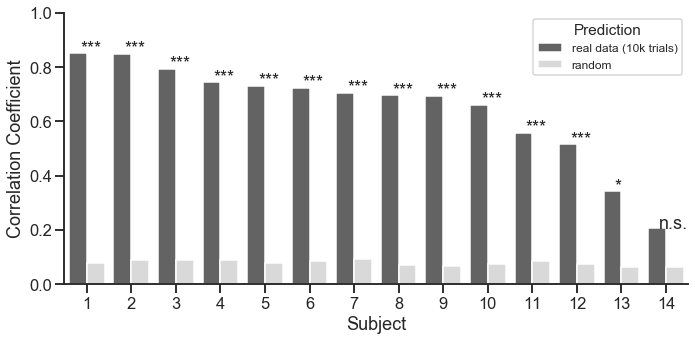

In [7]:
do_barplot();

In [8]:
def do_lineplot_f2(subject):
    
    """
    Plots the measured and predicted ABR for individual subjects. 
    Note that subjects are not orderd as in the barplot. 
    to obtain the same subject id as in the barplot look into df and select the right index.
    
    Input: 
        subject: digit referring to the index of a subject (can be 0-13)
    """
    
    # general seaborn setup
    sns.set_style('ticks')
    sns.set_context('talk', rc={'legend.fontsize': 12})
    
    # put into pandas df
    df_test = pd.concat([eeg['eeg_10k'][subject],
                         predictions['prediction_10k'][subject]], axis=1)
    df_test.columns = ['measured ABR (9Hz)', 'predicted ABR (9Hz)']
    df_test['time'] = np.arange(0.1,10.1,0.1)
    df_test.set_index('time', inplace=True)
    
     
    lplot = sns.lineplot(data=df_test,
                         linewidth=3,
                         palette='deep',
                         dashes=False)


    lplot.set_ylabel("Amplitude (zscore)")
    lplot.set_xlabel("Time (ms)")
    sns.despine()
    lplot.axis([0, 10, -4, 4])
    
    return lplot

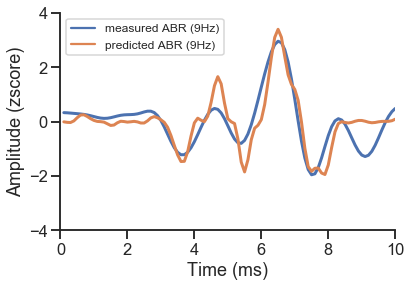

In [9]:
do_lineplot_f2(0);

In [12]:
def plot_prediction_matrix(subject_number):
    
    """
    Plots individual prediction matrices. Note that subjects are not orderd as in the barplot 
    to obtain the same subject as in the barplot look into df and select the right index.
       
    Input: subject_number: digit can be 0-13 referring to the index of a subject
    """
    
    img = plt.imshow(zscore(prediction_matrices[subject_number], axis=None),
                     cmap='vlag',
                     vmin=-4,
                     vmax=4,
                     interpolation='spline36');

    img.figure.set_size_inches(12, 12, forward=True)
    img.figure.colorbar(img, shrink=0.4);
    
    img.figure.gca().invert_yaxis()
    img.axes.plot(img.axes.get_xlim(), img.axes.get_ylim(), ls="--", c=".3")

    plt.axis([0, 100, 0, 100]);
    
    # dirty fix to display sampling points as ms
    img.axes.set_yticklabels(['0','2','4','6','8','10'])
    img.axes.set_xticklabels(['0','2','4','6','8','10'])
    
    img.axes.set_xlabel('testing time (ms) at 9Hz stimulation rate')
    img.axes.set_ylabel('training time (ms) at 30Hz stimulation rate')
    
    return img

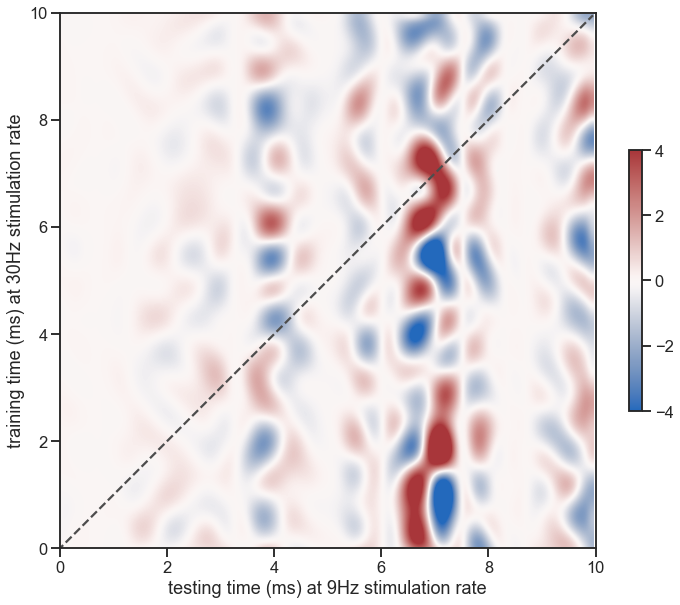

In [13]:
plot_prediction_matrix(0);